# DoS ML System

## Importing Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, Perceptron, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import joblib
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

from functions_ml import *
model_repo = ".\\DoS_system_3_models\\"
file_path = '.\Files\\DoS\\'

## Preprocessing data for binary classification (DoS (DDoS and DoS) or Benign)

In [2]:
train_sets, test_sets = get_train_and_test_files()
print(len(train_sets), len(test_sets))

X_columns = x_columns(read_csv_file(train_sets[0]))
print(len(X_columns))
y_column = 'label'

135 34
46


## Scaling

In [3]:
scaler = get_or_define_and_save_scaler(model_repo, train_sets, X_columns)

## Dictionnary for spliting data

In [3]:
dict_3_classes = {}
dict_3_classes['DDoS-RSTFINFlood'] = 'DoS'
dict_3_classes['DDoS-PSHACK_Flood'] = 'DoS'
dict_3_classes['DDoS-SYN_Flood'] = 'DoS'
dict_3_classes['DDoS-UDP_Flood'] = 'DoS'
dict_3_classes['DDoS-TCP_Flood'] = 'DoS'
dict_3_classes['DDoS-ICMP_Flood'] = 'DoS'
dict_3_classes['DDoS-SynonymousIP_Flood'] = 'DoS'
dict_3_classes['DDoS-ACK_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-UDP_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-ICMP_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-SlowLoris'] = 'DoS'
dict_3_classes['DDoS-HTTP_Flood'] = 'DoS'
dict_3_classes['DoS-UDP_Flood'] = 'DoS'
dict_3_classes['DoS-SYN_Flood'] = 'DoS'
dict_3_classes['DoS-TCP_Flood'] = 'DoS'
dict_3_classes['DoS-HTTP_Flood'] = 'DoS'

dict_3_classes['BenignTraffic'] = 'Benign'

dict_3_classes['Mirai-greeth_flood'] = 'Other'
dict_3_classes['Mirai-greip_flood'] = 'Other'
dict_3_classes['Mirai-udpplain'] = 'Other'
dict_3_classes['Recon-PingSweep'] = 'Other'
dict_3_classes['Recon-OSScan'] = 'Other'
dict_3_classes['Recon-PortScan'] = 'Other'
dict_3_classes['VulnerabilityScan'] = 'Other'
dict_3_classes['Recon-HostDiscovery'] = 'Other'
dict_3_classes['DNS_Spoofing'] = 'Other'
dict_3_classes['MITM-ArpSpoofing'] = 'Other'
dict_3_classes['BrowserHijacking'] = 'Other'
dict_3_classes['Backdoor_Malware'] = 'Other'
dict_3_classes['XSS'] = 'Other'
dict_3_classes['Uploading_Attack'] = 'Other'
dict_3_classes['SqlInjection'] = 'Other'
dict_3_classes['CommandInjection'] = 'Other'
dict_3_classes['DictionaryBruteForce'] = 'Other'

## Refactoring data

In [4]:
train_sets.extend(test_sets)
refactor_dataframe(train_sets, dict_3_classes, file_path, y_column)

100%|██████████| 168/168 [15:07<00:00,  5.40s/it]


## Counting number of samples per class

In [5]:
train_sets, test_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(train_sets) + len(test_sets))

95


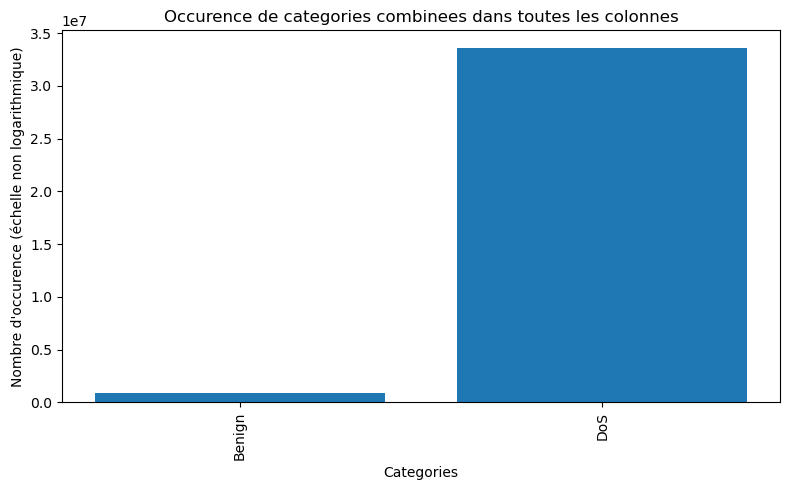

In [6]:
plot_bar_chart(count_label(train_sets, file_path=file_path), 'Occurence de categories combinees dans toutes les colonnes', 'Categories', 'Nombre d\'occurence', 8, 5, log_scale=False)

## Define variables

In [4]:
performance_path = 'performance.csv'
file_path = '.\Files\\DoS\\'
model_path_binary = '.\\DoS_system_3_models\\Binary\\'
# local_path = '.\\Recon_model\\'
model_path_trinary = '.\\DoS_system_3_models\\Trinary\\'
model_path_all_classes_DoS = '.\\DoS_system_3_models\\All_classes\\DoS\\'
model_path_all_classes_DDoS = '.\\DoS_system_3_models\\All_classes\\DDoS\\'
# after_build_csv = 'after_build_set_scaled.csv'

# Get path data
build_sets, after_build_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(build_sets) + len(after_build_sets))

# Get build datasets
build_nb = round(len(build_sets) * 0.8)
train_sets = build_sets[:build_nb]
# train_sets = train_sets[: round(len(train_sets) * 0.5)]
test_sets = build_sets[build_nb:]
# test_sets = test_sets[: round(len(test_sets) * 0.5)]

# Define different columns
X_columns = x_columns(read_csv_file(train_sets[0], path_to_datasets=file_path))
X_columns = X_columns[:-2]
print(len(X_columns))
y_column = 'label'
z_column = 'Binary'

95
46


## First model Binary (DoS (DDoS and DoS) or Benign)

## Buiding models

In [6]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "ET",
        "Model": ExtraTreesClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
    {
        "Name": "Cat",
        "Model": CatBoostClassifier(random_state = 42, verbose = 0)
    },
    {
        "Name": "LIGHT",
        "Model": LGBMClassifier(random_state = 42, verbose = 0)
    },
    {
        "Name": "GBoost",
        "Model": GradientBoostingClassifier(random_state = 42)
    },
    {
        "Name": "Adaboost",
        "Model": AdaBoostClassifier(random_state = 42)
    },
    {
        "Name": "MLP",
        "Model": MLPClassifier(hidden_layer_sizes = (100,20), max_iter = 300, activation = 'relu', solver = 'adam', random_state = 42)
    },
]

In [ ]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_binary)
performance = get_or_define_performance_df(model_path_binary, performance_path)

# Buidling models
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model(model['Model'], model['Name'], train_sets, test_sets, file_path, performance, model_path_binary, X_columns=X_columns , y_column=z_column, encoder=encoder, scaler=scaler, confusionMatrix=False)

    # Save performance
    performance.to_csv(model_path_binary + performance_path, index=False)

# Save the encoder to a file
joblib.dump(encoder, model_path_binary+'encoder.joblib')

## Feature importance

100%|██████████| 8/8 [00:00<00:00, 185.86it/s]


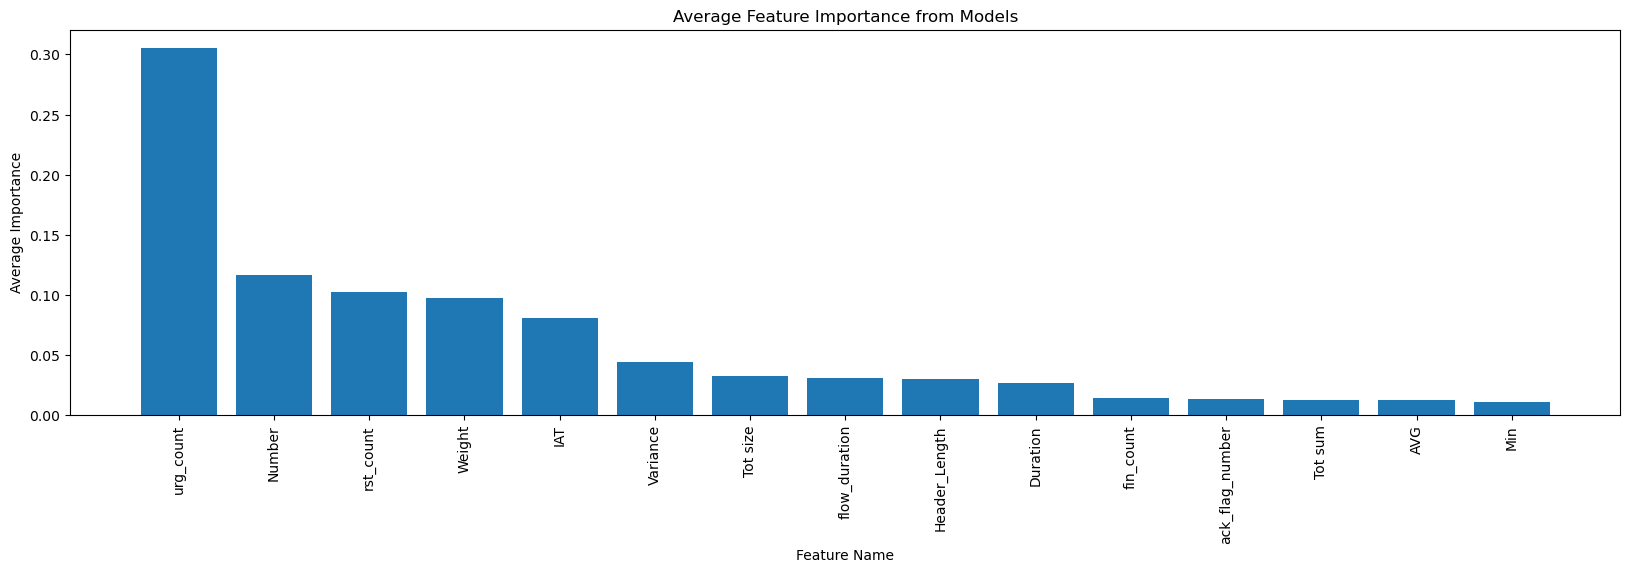

,Feature,Average Importance
17,urg_count,0.305227
40,Number,0.116680
18,rst_count,0.102050
45,Weight,0.097557
39,IAT,0.080285
44,Variance,0.043858
38,Tot size,0.032153
0,flow_duration,0.030578
1,Header_Length,0.029797
3,Duration,0.026316


In [7]:
# Import encoder and get all features
encoder = get_encoder(model_path_binary, "Please, build models first")

simpleModelsDef = model_dict_refactor_with_load_model(simpleModelsDef, model_path_binary)

# Get feature importance
average_importance_df = calculate_and_plot_feature_importance(simpleModelsDef, train_sets, X_columns, z_column, X_columns, file_path, fitted_models=True, filter_bool=False, scaler=scaler, encoder=encoder)
average_importance_df.to_csv('.\\resultats\\DoS_3_models\\Binary\\feature_importance.csv', index=False)
average_importance_df.head(average_importance_df.size)

## Display performance

In [10]:
# Preprocessing if necessary
performance = read_csv_file(performance_path, model_path_binary)
performance = performance.drop(0).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

performance.head()
# performance.to_csv(model_path_binary + performance_path, index=False)

In [11]:
read_csv_file(performance_path, model_path_binary).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
6,GBoost,1.000000,1.000000,0.999999,0.999999,0.999994,0.999976,0.999909,0.999943,0.000001,0.000005,8,34,7389386
1,XGB,1.000000,1.000000,0.999999,1.000000,0.999994,0.999961,0.999914,0.999937,0.000002,0.000004,14,32,7389386
0,RF,1.000000,1.000000,1.000000,1.000000,0.999994,0.999973,0.999898,0.999936,0.000001,0.000005,9,38,7389386
4,Cat,1.000000,1.000000,1.000000,1.000000,0.999994,0.999963,0.999906,0.999934,0.000002,0.000005,13,35,7389386
7,Adaboost,1.000000,1.000000,1.000000,1.000000,0.999992,0.999931,0.999902,0.999917,0.000003,0.000005,25,36,7389386
3,ET,1.000000,1.000000,1.000000,1.000000,0.999990,0.999948,0.999842,0.999895,0.000002,0.000008,18,59,7389386
5,LIGHT,1.000000,1.000000,1.000000,1.000000,0.999989,0.999896,0.999880,0.999888,0.000005,0.000006,38,44,7389386
8,MLP,0.999973,0.999909,0.999540,0.999724,0.999976,0.999866,0.999654,0.999760,0.000006,0.000017,47,129,7389386
2,DT,1.000000,1.000000,1.000000,1.000000,0.999928,0.999445,0.999109,0.999277,0.000027,0.000045,200,330,7389386


## Do prediction for after build sets

In [5]:
# Define model
model_path = '.\\DoS_model\\Binary\\'
model = joblib.load(model_path + 'model_XGB.joblib')

try:
    # scaler = joblib.load(model_path+'scaler.joblib')
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    raise Exception("Please, build models first")

# Get prediction
X_test, y_test, y_pred, z_test = get_prediction_by_model(model, after_build_sets, file_path, X_columns, y_column=z_column, z_column=y_column, scale=True, encode=True, scaler=scaler, encoder=encoder)

# Build new dataframe and save it
new_after_build_set_scaled = pd.DataFrame(X_test, columns=X_columns)
new_after_build_set_scaled[z_column] = encoder.inverse_transform(y_test)
new_after_build_set_scaled['Prediction'] = encoder.inverse_transform(y_pred)
# new_after_build_set_scaled['Trinary'] = trinary_col.values
new_after_build_set_scaled[y_column] = z_test
count = len(new_after_build_set_scaled[new_after_build_set_scaled[z_column] != new_after_build_set_scaled['Prediction']])

new_after_build_set_scaled.to_csv('.\\DoS_model\\after_build_set_scaled.csv', index=False)

# Get performance
res = pd.DataFrame([[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'), count, count / len(new_after_build_set_scaled) * 100,len(new_after_build_set_scaled)]], columns=['Accuracy', 'Recall', 'Precision', 'F1', 'Mispredicted count', 'Mispredicted rate', 'Total rows'])

del new_after_build_set_scaled

res.head()

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:30<00:00,  1.62s/it]


,Accuracy,Recall,Precision,F1,Mispredicted count,Mispredicted rate,Total rows
0,0.999992,0.999992,0.999992,0.999992,67,0.00077,8703485


# Second model Binary (DDoS or DoS)

## New column dictionnary

In [6]:
dict_3_classes = {}
dict_3_classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_3_classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_3_classes['DDoS-SYN_Flood'] = 'DDoS'
dict_3_classes['DDoS-UDP_Flood'] = 'DDoS'
dict_3_classes['DDoS-TCP_Flood'] = 'DDoS'
dict_3_classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_3_classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_3_classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_3_classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_3_classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_3_classes['DDoS-SlowLoris'] = 'DDoS'
dict_3_classes['DDoS-HTTP_Flood'] = 'DDoS'
dict_3_classes['DoS-UDP_Flood'] = 'DoS'
dict_3_classes['DoS-SYN_Flood'] = 'DoS'
dict_3_classes['DoS-TCP_Flood'] = 'DoS'
dict_3_classes['DoS-HTTP_Flood'] = 'DoS'

dict_3_classes['BenignTraffic'] = 'Other'
dict_3_classes['Mirai-greeth_flood'] = 'Other'
dict_3_classes['Mirai-greip_flood'] = 'Other'
dict_3_classes['Mirai-udpplain'] = 'Other'
dict_3_classes['Recon-PingSweep'] = 'Other'
dict_3_classes['Recon-OSScan'] = 'Other'
dict_3_classes['Recon-PortScan'] = 'Other'
dict_3_classes['VulnerabilityScan'] = 'Other'
dict_3_classes['Recon-HostDiscovery'] = 'Other'
dict_3_classes['DNS_Spoofing'] = 'Other'
dict_3_classes['MITM-ArpSpoofing'] = 'Other'
dict_3_classes['BrowserHijacking'] = 'Other'
dict_3_classes['Backdoor_Malware'] = 'Other'
dict_3_classes['XSS'] = 'Other'
dict_3_classes['Uploading_Attack'] = 'Other'
dict_3_classes['SqlInjection'] = 'Other'
dict_3_classes['CommandInjection'] = 'Other'
dict_3_classes['DictionaryBruteForce'] = 'Other'

## New column adding

In [ ]:
temp_df = build_sets.copy()
temp_df.extend(after_build_sets)
add_column_by_another_to_datasets(file_path, temp_df, 'Trinary', 'label', dict_3_classes)

In [7]:
add_column_by_another_to_datasets('.\\DoS_model\\', ['after_build_set_scaled.csv'], 'Trinary', 'label', dict_3_classes)

100%|██████████| 1/1 [03:24<00:00, 204.72s/it]


## Build model and Display these performance

In [10]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "ET",
        "Model": ExtraTreesClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
    {
        "Name": "Cat",
        "Model": CatBoostClassifier(random_state = 42, verbose = 0)
    },
    {
        "Name": "LIGHT",
        "Model": LGBMClassifier(random_state = 42, verbose = 0)
    },
    {
        "Name": "GBoost",
        "Model": GradientBoostingClassifier(random_state = 42)
    },
    {
        "Name": "Adaboost",
        "Model": AdaBoostClassifier(random_state = 42)
    },
    {
        "Name": "MLP",
        "Model": MLPClassifier(hidden_layer_sizes = (100,20), max_iter = 300, activation = 'relu', solver = 'adam', random_state = 42)
    },
]

In [13]:
filter_name = [
    {'name': 'DoS', 'type': '='},
    {'name': 'Other', 'type': '!'}
]
filter_cols = ['Binary', 'Trinary']

In [ ]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_trinary)
performance = get_or_define_performance_df(model_path_trinary, performance_path)

# Buidling models
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model_multifiltered(model['Model'], model['Name'], train_sets, test_sets, file_path, performance, model_path_trinary, X_columns=X_columns , y_column='Trinary', filter_cols=filter_cols, filter_bool=True, filter_name=filter_name, encoder=encoder, scaler=scaler, confusionMatrix=False)

    # Save performance
    performance.to_csv(model_path_trinary + performance_path, index=False)

joblib.dump(encoder, model_path_trinary+'encoder.joblib')

In [11]:
encoder = joblib.load(model_path_trinary+'encoder.joblib')
num_classes = encoder.classes_
print("Nombre de classes :", len(num_classes), num_classes)

Nombre de classes : 2 ['DDoS' 'DoS']


## Feature Importance

100%|██████████| 8/8 [00:00<00:00, 83.02it/s]


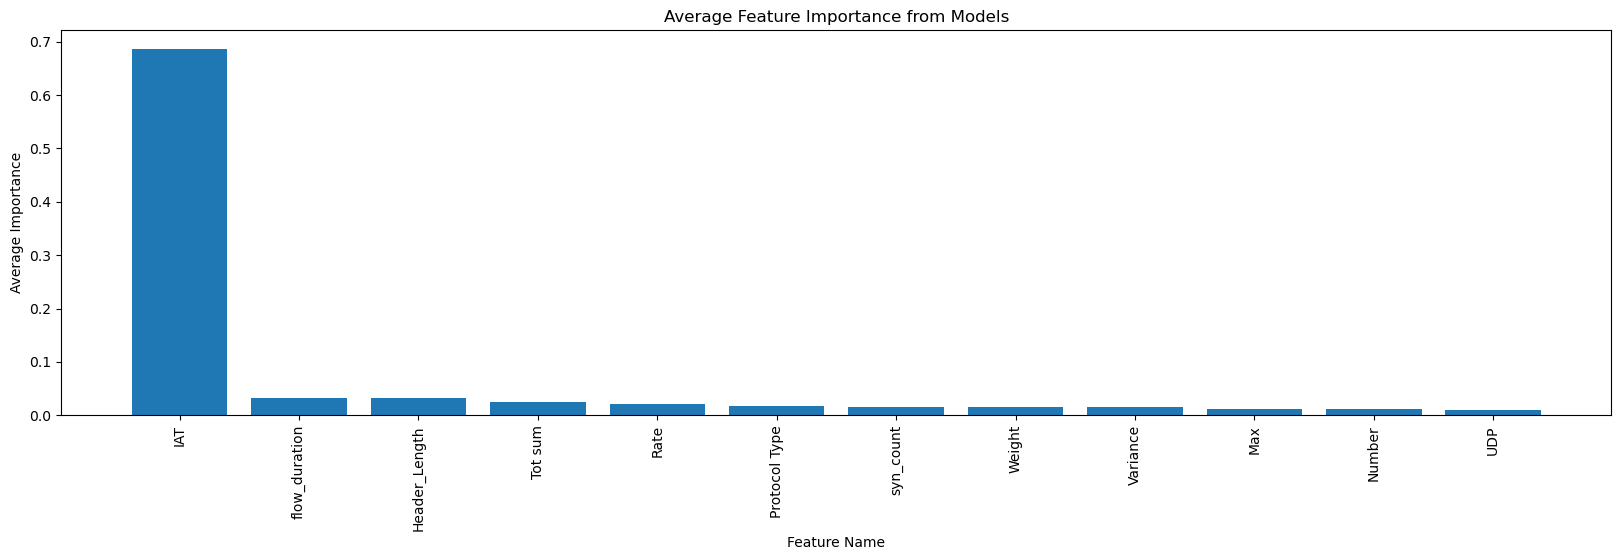

,Feature,Average Importance
39,IAT,0.687334
0,flow_duration,0.032741
1,Header_Length,0.032691
33,Tot sum,0.024039
4,Rate,0.020153
2,Protocol Type,0.016698
15,syn_count,0.016126
45,Weight,0.014964
44,Variance,0.014692
35,Max,0.012343


In [11]:
# Import encoder and get all features
encoder = get_encoder(model_path_trinary, "Please, build models first")

simpleModelsDef = model_dict_refactor_with_load_model(simpleModelsDef, model_path_trinary)

# Get feature importance
average_importance_df = calculate_and_plot_feature_importance(simpleModelsDef, train_sets, X_columns, z_column, X_columns, file_path, fitted_models=True, filter_bool=False, scaler=scaler, encoder=encoder)
average_importance_df.to_csv('.\\resultats\\DoS_3_models\\Trinary\\feature_importance.csv', index=False)
average_importance_df.head(average_importance_df.size)

## Display performance

In [11]:
# Preprocessing if necessary
performance = read_csv_file(performance_path, model_path_trinary)
performance = performance.drop(0).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

performance.head()
# performance.to_csv(model_path_trinary + performance_path, index=False)

In [16]:
read_csv_file(performance_path, model_path_trinary).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
3,XGB,1.000000,1.000000,1.000000,1.000000,0.999908,0.999826,0.999877,0.999852,0.000033,0.000059,238,425,7201481
7,GBoost,0.999968,0.999933,0.999965,0.999949,0.999904,0.999803,0.999888,0.999845,0.000027,0.000069,192,500,7201481
0,DT,1.000000,1.000000,1.000000,1.000000,0.999896,0.999811,0.999854,0.999833,0.000041,0.000063,295,453,7201481
6,Adaboost,0.999928,0.999840,0.999930,0.999885,0.999867,0.999696,0.999876,0.999786,0.000021,0.000112,151,805,7201481
1,RF,1.000000,1.000000,1.000000,1.000000,0.999860,0.999712,0.999837,0.999774,0.000038,0.000102,276,732,7201481
4,Cat,0.999880,0.999707,0.999908,0.999807,0.999784,0.999514,0.999792,0.999652,0.000038,0.000178,272,1281,7201481
5,LIGHT,0.999949,0.999875,0.999962,0.999919,0.999784,0.999535,0.999769,0.999652,0.000049,0.000167,354,1203,7201481
2,ET,1.000000,1.000000,1.000000,1.000000,0.998350,0.996531,0.998147,0.997336,0.000417,0.001233,3004,8882,7201481


## Trinary prediction on already Binary predicted after build set 

In [9]:
model_path = '.\\DoS_model\\Trinary\\'
filter_name = [
    {'name': 'DoS', 'type': '='},
    {'name': 'Other', 'type': '!'}
]
filter_cols = ['Prediction', 'Trinary']

# Define model
model = joblib.load(model_path + 'model_XGB.joblib')

# Get predicted data
df = read_csv_file('after_build_set_scaled.csv', '.\\DoS_model\\')
print(len(df))
df = df[df['Prediction'] == 'DoS']
df = df[df['Trinary'] != 'Other']
print(len(df))
df.head()

# Get x, y and z
binary_col = df['Binary']
prediction_col = df['Prediction']
label_col = df[y_column]
del df

try:
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    raise Exception("Please, build models first")

# Get prediction
X_test, y_test, y_pred = get_prediction_by_model_multifiltered(model, ['after_build_set_scaled.csv'], '.\\DoS_model\\', X_columns, y_column='Trinary', filter_cols=filter_cols, filter_bool=True, filter_name=filter_name, scale=True, encode=False, scaler=scaler, encoder=encoder)
print(np.array(X_test).shape)

# Build new dataframe and save it
new_after_build_set_scaled = pd.DataFrame(X_test, columns=X_columns)
new_after_build_set_scaled[y_column] = label_col.values
new_after_build_set_scaled['Trinary'] = y_test
new_after_build_set_scaled['Trinary Prediction'] = encoder.inverse_transform(y_pred)
new_after_build_set_scaled['Binary'] = binary_col.values
new_after_build_set_scaled['Prediction'] = prediction_col.values
count = len(new_after_build_set_scaled[new_after_build_set_scaled['Trinary'] != new_after_build_set_scaled['Trinary Prediction']])
y_pred = encoder.inverse_transform(y_pred)

new_after_build_set_scaled.to_csv('.\\DoS_model\\after_build_set_scaled.csv', index=False)

# Get performance
res = pd.DataFrame([[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'), count, count / len(new_after_build_set_scaled),len(new_after_build_set_scaled)]], columns=['Accuracy', 'Recall', 'Precision', 'F1', 'Mispredicted count', 'Mispredicted rate', 'Total rows']).head()

del new_after_build_set_scaled

res.head()

8703485
8482125


100%|██████████| 1/1 [00:38<00:00, 38.42s/it]


(8482125, 46)


,Accuracy,Recall,Precision,F1,Mispredicted count,Mispredicted rate,Total rows
0,0.999909,0.999909,0.999909,0.999909,768,0.000091,8482125


In [10]:
df = read_csv_file('after_build_set_scaled.csv', '.\\DoS_model\\')
df.head(40)

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Magnitue,Radius,Covariance,Variance,Weight,label,Trinary,Trinary Prediction,Binary,Prediction
0,4.523137,108.00,6.00,64.00,0.442171,0.442171,0.0,0.0,0.0,0.0,...,10.392305,0.000000,0.000000,0.00,141.55,DDoS-PSHACK_Flood,DDoS,DDoS,DoS,DoS
1,0.000000,54.00,6.00,64.00,7.362090,7.362090,0.0,1.0,0.0,1.0,...,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood,DDoS,DDoS,DoS,DoS
2,0.000000,53.46,5.94,63.36,463.484612,463.484612,0.0,0.0,0.0,0.0,...,10.392912,0.037895,0.035900,0.02,141.55,DDoS-PSHACK_Flood,DDoS,DDoS,DoS,DoS
3,0.000000,54.00,6.00,64.00,2.730065,2.730065,0.0,0.0,0.0,0.0,...,10.392305,0.000000,0.000000,0.00,141.55,DDoS-PSHACK_Flood,DDoS,DDoS,DoS,DoS
4,0.125939,17028.92,16.50,66.56,5027.499047,5027.499047,0.0,0.0,0.0,0.0,...,10.089039,4.606503,113.355389,0.19,141.55,DDoS-UDP_Flood,DDoS,DDoS,DoS,DoS
5,0.000000,54.00,6.00,64.00,11.477777,11.477777,0.0,0.0,0.0,0.0,...,10.392305,0.000000,0.000000,0.00,141.55,DDoS-TCP_Flood,DDoS,DDoS,DoS,DoS
6,0.000000,0.00,1.00,64.00,1.244309,1.244309,0.0,0.0,0.0,0.0,...,9.165151,0.000000,0.000000,0.00,141.55,DDoS-ICMP_Flood,DDoS,DDoS,DoS,DoS
7,0.000000,182.00,17.00,64.00,62.697939,62.697939,0.0,0.0,0.0,0.0,...,19.078784,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood,DoS,DoS,DoS,DoS
8,0.019006,15910.00,17.00,64.00,16639.720789,16639.720789,0.0,0.0,0.0,0.0,...,9.987782,0.322221,0.373822,0.14,141.55,DoS-UDP_Flood,DoS,DoS,DoS,DoS
9,0.055484,21426.00,17.00,64.00,7527.965587,7527.965587,0.0,0.0,0.0,0.0,...,10.000000,0.000000,0.000000,0.00,141.55,DDoS-UDP_Flood,DDoS,DDoS,DoS,DoS


In [27]:
del df

# Third model (DoS)

## Building model

In [12]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "ET",
        "Model": ExtraTreesClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
    {
        "Name": "Cat",
        "Model": CatBoostClassifier(random_state = 42, verbose = 0)
    },
    {
        "Name": "LIGHT",
        "Model": LGBMClassifier(random_state = 42, verbose = 0)
    },
    {
        "Name": "GBoost",
        "Model": GradientBoostingClassifier(random_state = 42)
    },
    {
        "Name": "Adaboost",
        "Model": AdaBoostClassifier(random_state = 42)
    },
    {
        "Name": "MLP",
        "Model": MLPClassifier(hidden_layer_sizes = (100,20), max_iter = 300, activation = 'relu', solver = 'adam', random_state = 42)
    },
]

In [18]:
filter_name = [
    {'name': 'DoS', 'type': '='},
    {'name': 'DoS', 'type': '='},
]
filter_cols = ['Binary', 'Trinary']

In [31]:
encoder = joblib.load(model_path_all_classes_DoS+'encoder.joblib')
num_classes = encoder.classes_
print("Nombre de classes :", len(num_classes), num_classes)

Nombre de classes : 4 ['DoS-HTTP_Flood' 'DoS-SYN_Flood' 'DoS-TCP_Flood' 'DoS-UDP_Flood']


In [ ]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_all_classes_DoS)
performance = get_or_define_performance_df(model_path_all_classes_DoS, performance_path)

# Buidling models
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model_multifiltered(model['Model'], model['Name'], train_sets, test_sets, file_path, performance, model_path_all_classes_DoS, X_columns=X_columns , y_column=y_column, filter_cols=filter_cols, filter_bool=True, filter_name=filter_name, encoder=encoder, scaler=scaler, confusionMatrix=False)

    # Save performance
    performance.to_csv(model_path_all_classes_DoS + performance_path, index=False)

joblib.dump(encoder, model_path_all_classes_DoS+'encoder.joblib')

## Feature Importance

100%|██████████| 8/8 [00:00<00:00, 189.94it/s]


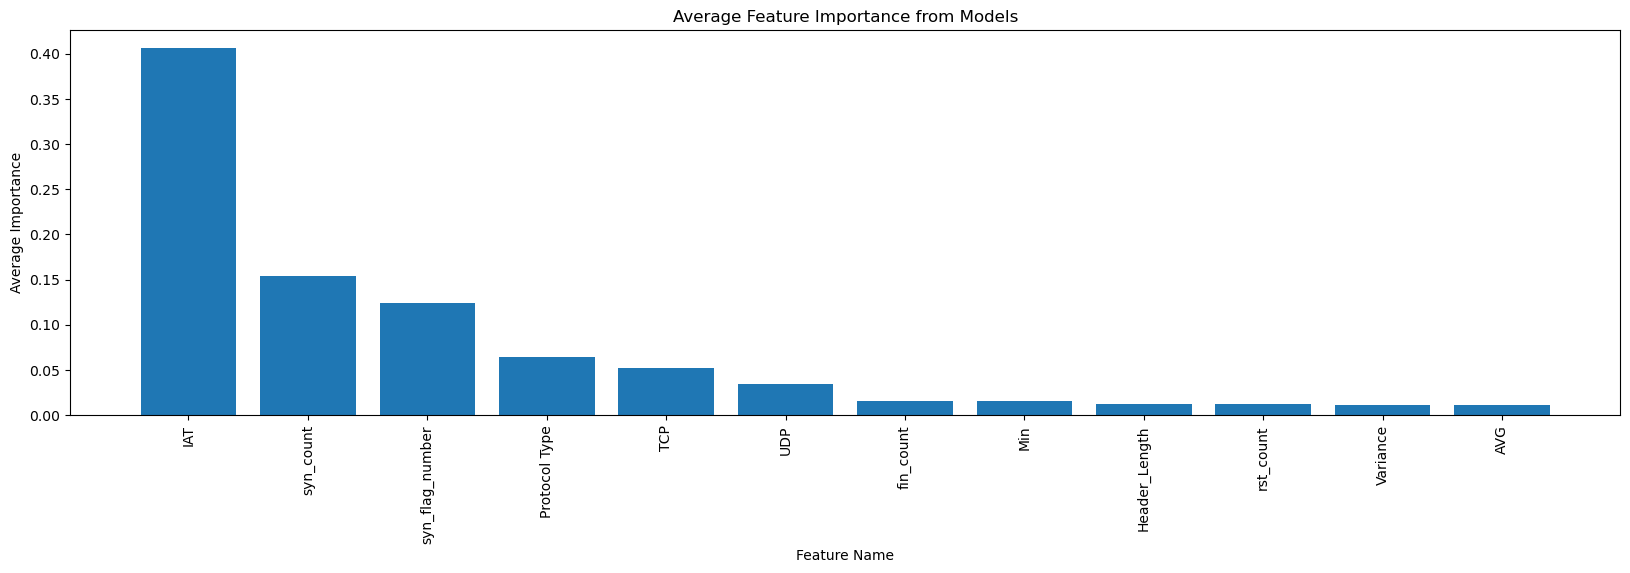

,Feature,Average Importance
39,IAT,0.405733
15,syn_count,0.154235
8,syn_flag_number,0.123955
2,Protocol Type,0.063881
26,TCP,0.052082
27,UDP,0.034500
16,fin_count,0.015475
34,Min,0.015153
1,Header_Length,0.012753
18,rst_count,0.012629


In [13]:
# Import encoder and get all features
encoder = get_encoder(model_path_all_classes_DoS, "Please, build models first")

simpleModelsDef = model_dict_refactor_with_load_model(simpleModelsDef, model_path_all_classes_DoS)

# Get feature importance
average_importance_df = calculate_and_plot_feature_importance(simpleModelsDef, train_sets, X_columns, z_column, X_columns, file_path, fitted_models=True, filter_bool=False, scaler=scaler, encoder=encoder)
average_importance_df.to_csv('.\\resultats\\DoS_3_models\\DoS\\feature_importance.csv', index=False)
average_importance_df.head(average_importance_df.size)

## Display performance

In [37]:
# Preprocessing if necessary

performance = read_csv_file(performance_path, model_path_all_classes_DoS)
performance = performance.drop(0).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

performance.head()
# performance.to_csv(model_path_all_classes_DoS + performance_path, index=False)

In [20]:
read_csv_file(performance_path, model_path_all_classes_DoS).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
2,XGB,1.000000,1.000000,1.000000,1.000000,0.999949,0.999352,0.999805,0.999578,0.000033,0.000018,46,25,1382998
7,GBoost,1.000000,1.000000,1.000000,1.000000,0.999943,0.999309,0.999481,0.999395,0.000026,0.000031,36,43,1382998
4,Cat,1.000000,1.000000,1.000000,1.000000,0.999898,0.998469,0.999269,0.998868,0.000069,0.000033,95,46,1382998
5,LIGHT,1.000000,1.000000,1.000000,1.000000,0.999889,0.998718,0.999200,0.998958,0.000059,0.000051,82,71,1382998
0,DT,1.000000,1.000000,1.000000,1.000000,0.999855,0.998459,0.998850,0.998654,0.000083,0.000062,115,86,1382998
1,RF,1.000000,1.000000,1.000000,1.000000,0.999846,0.998609,0.999030,0.998819,0.000072,0.000082,100,113,1382998
3,ET,1.000000,1.000000,1.000000,1.000000,0.999012,0.993067,0.994791,0.993925,0.000473,0.000515,654,712,1382998
6,Adaboost,0.988003,0.974196,0.972019,0.973012,0.991719,0.983593,0.882257,0.917068,0.000610,0.007671,844,10609,1382998


## Final DoS prediction

In [12]:
model_path = '.\\DoS_model\\All_classes\\DoS\\'
filter_name = [
    {'name': 'DoS', 'type': '='},
    {'name': 'DoS', 'type': '='}
]
filter_cols = ['Prediction', 'Trinary Prediction']

# Define model
model = joblib.load(model_path + 'model_XGB.joblib')

# Get predicted data
df = read_csv_file('after_build_set_scaled.csv', '.\\DoS_model\\')
print(len(df))
# df = df[df['Prediction'] == 'DoS']
# df = df[df['Trinary Prediction'] == 'DoS']
df = multi_filter_df(df, filter_cols, filter_name)
print(len(df))

# Get x, y and z
binary_col = df['Binary']
prediction_col = df['Prediction']
trinary_col = df['Trinary']
trinary_prediction_col = df['Trinary Prediction']
del df

try:
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    raise Exception("Please, build models first")

# Get prediction
X_test, y_test, y_pred = get_prediction_by_model_multifiltered(model, ['after_build_set_scaled.csv'], '.\\DoS_model\\', X_columns, y_column=y_column, filter_cols=filter_cols, filter_bool=True, filter_name=filter_name, scale=True, encode=False, scaler=scaler, encoder=encoder)
print(np.array(X_test).shape)

# Build new dataframe and save it
new_after_build_set_scaled = pd.DataFrame(X_test, columns=X_columns)
new_after_build_set_scaled[y_column] = y_test
new_after_build_set_scaled['Final DoS Prediction'] = encoder.inverse_transform(y_pred)
new_after_build_set_scaled['Binary'] = binary_col.values
new_after_build_set_scaled['Prediction'] = prediction_col.values
new_after_build_set_scaled['Trinary'] = trinary_col.values
new_after_build_set_scaled['Trinary Prediction'] = trinary_prediction_col.values
count = len(new_after_build_set_scaled[new_after_build_set_scaled[y_column] != new_after_build_set_scaled['Final DoS Prediction']])
y_pred = encoder.inverse_transform(y_pred)

# Get performance
res = pd.DataFrame([[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'), count, count / len(new_after_build_set_scaled),len(new_after_build_set_scaled)]], columns=['Accuracy', 'Recall', 'Precision', 'F1', 'Mispredicted count', 'Mispredicted rate', 'Total rows']).head()

res.head()

8482125
1631183


100%|██████████| 1/1 [00:35<00:00, 35.53s/it]


(1631183, 46)


,Accuracy,Recall,Precision,F1,Mispredicted count,Mispredicted rate,Total rows
0,0.999804,0.999804,0.999628,0.999716,320,0.000196,1631183


In [13]:
new_after_build_set_scaled.head(20)

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Radius,Covariance,Variance,Weight,label,Final DoS Prediction,Binary,Prediction,Trinary,Trinary Prediction
0,0.000000,182.00,17.00,64.00,62.697939,62.697939,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood,DoS-UDP_Flood,DoS,DoS,DoS,DoS
1,0.019006,15910.00,17.00,64.00,16639.720789,16639.720789,0.0,0.0,0.0,0.0,...,0.322221,0.373822,0.14,141.55,DoS-UDP_Flood,DoS-UDP_Flood,DoS,DoS,DoS,DoS
2,0.000000,53.46,5.94,63.36,202.757247,202.757247,0.0,0.0,0.0,0.0,...,0.057331,0.054789,0.03,141.55,DoS-TCP_Flood,DoS-TCP_Flood,DoS,DoS,DoS,DoS
3,0.000000,182.00,17.00,64.00,9.417466,9.417466,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood,DoS-UDP_Flood,DoS,DoS,DoS,DoS
4,0.000000,81.20,6.11,64.00,28.029578,28.029578,0.0,0.0,0.0,0.0,...,1.411650,6.126863,0.17,141.55,DoS-TCP_Flood,DoS-TCP_Flood,DoS,DoS,DoS,DoS
5,0.000000,55.76,6.11,65.91,1.945530,1.945530,0.0,0.0,0.0,0.0,...,7.727394,251.990633,0.12,141.55,DoS-TCP_Flood,DoS-TCP_Flood,DoS,DoS,DoS,DoS
6,0.010252,10048.50,16.83,63.36,20049.876592,20049.876592,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood,DoS-UDP_Flood,DoS,DoS,DoS,DoS
7,0.000000,54.00,6.00,64.00,3.060749,3.060749,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00,141.55,DoS-TCP_Flood,DoS-TCP_Flood,DoS,DoS,DoS,DoS
8,0.013626,165.64,16.89,64.41,10.174500,10.174500,0.0,0.0,0.0,0.0,...,14.328432,656.017230,0.19,141.55,DoS-UDP_Flood,DoS-UDP_Flood,DoS,DoS,DoS,DoS
9,0.019044,3825.00,17.00,64.00,6251.809669,6251.809669,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.00,141.55,DoS-UDP_Flood,DoS-UDP_Flood,DoS,DoS,DoS,DoS


In [14]:
del new_after_build_set_scaled

# Third model (DDoS)

## Building model

In [14]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    {
        "Name": "ET",
        "Model": ExtraTreesClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
    {
        "Name": "Cat",
        "Model": CatBoostClassifier(random_state = 42, verbose = 0)
    },
    {
        "Name": "LIGHT",
        "Model": LGBMClassifier(random_state = 42, verbose = 0)
    },
    # {
    #     "Name": "GBoost",
    #     "Model": GradientBoostingClassifier(random_state = 42)
    # },
    {
        "Name": "Adaboost",
        "Model": AdaBoostClassifier(random_state = 42)
    },
    # {
    #     "Name": "MLP",
    #     "Model": MLPClassifier(hidden_layer_sizes = (100,20), max_iter = 300, activation = 'relu', solver = 'adam', random_state = 42)
    # },
]

In [12]:
filter_name = [
    {'name': 'DoS', 'type': '='},
    {'name': 'DDoS', 'type': '='},
]
filter_cols = ['Binary', 'Trinary']

In [46]:
encoder = joblib.load(model_path+'encoder.joblib')
num_classes = encoder.classes_
print("Nombre de classes :", len(num_classes), num_classes)

Nombre de classes : 12 ['DDoS-ACK_Fragmentation' 'DDoS-HTTP_Flood' 'DDoS-ICMP_Flood'
 'DDoS-ICMP_Fragmentation' 'DDoS-PSHACK_Flood' 'DDoS-RSTFINFlood'
 'DDoS-SYN_Flood' 'DDoS-SlowLoris' 'DDoS-SynonymousIP_Flood'
 'DDoS-TCP_Flood' 'DDoS-UDP_Flood' 'DDoS-UDP_Fragmentation']


In [ ]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_all_classes_DDoS)
performance = get_or_define_performance_df(model_path_all_classes_DDoS, performance_path)

# Buidling models
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model_multifiltered(model['Model'], model['Name'], train_sets, test_sets, file_path, performance, model_path_all_classes_DDoS, X_columns=X_columns , y_column=y_column, filter_cols=filter_cols, filter_bool=True, filter_name=filter_name, encoder=encoder, scaler=scaler, confusionMatrix=False)

    # Save performance
    performance.to_csv(model_path_all_classes_DDoS + performance_path, index=False)

joblib.dump(encoder, model_path_all_classes_DDoS+'encoder.joblib')

## Feature Importance

100%|██████████| 7/7 [00:00<00:00, 143.96it/s]


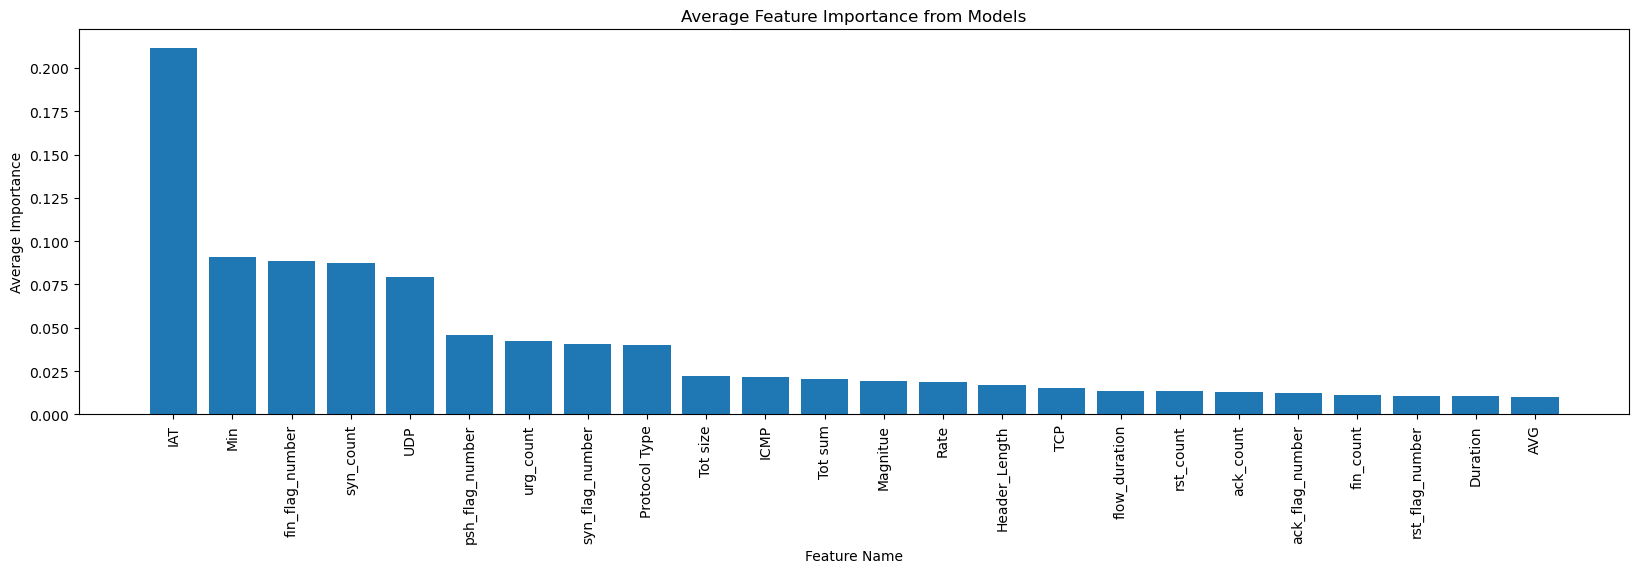

,Feature,Average Importance
39,IAT,0.211570
34,Min,0.090670
7,fin_flag_number,0.088766
15,syn_count,0.087143
27,UDP,0.079543
10,psh_flag_number,0.045843
17,urg_count,0.042149
8,syn_flag_number,0.040452
2,Protocol Type,0.039845
38,Tot size,0.022105


In [15]:
# Import encoder and get all features
encoder = get_encoder(model_path_all_classes_DDoS, "Please, build models first")

simpleModelsDef = model_dict_refactor_with_load_model(simpleModelsDef, model_path_all_classes_DDoS)

# Get feature importance
average_importance_df = calculate_and_plot_feature_importance(simpleModelsDef, train_sets, X_columns, z_column, X_columns, file_path, fitted_models=True, filter_bool=False, scaler=scaler, encoder=encoder)
average_importance_df.to_csv('.\\resultats\\DoS_3_models\\DDoS\\feature_importance.csv', index=False)
average_importance_df.head(average_importance_df.size)

## Display performance

In [8]:
read_csv_file(performance_path, model_path_all_classes_DDoS).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(20)

,Model,Accuracy Training,Recall Training,Precision Training,F1 Training,Accuracy Testing,Recall Testing,Precision Testing,F1 Testing,FU_rate,FL_rate,FU,FL,Total rows
2,XGB,1.000000,1.000000,1.000000,1.000000,0.999907,0.997951,0.998336,0.998141,0.000051,0.000042,297,244,5818483
0,DT,1.000000,1.000000,1.000000,1.000000,0.999755,0.996045,0.995139,0.995588,0.000106,0.000138,619,804,5818483
4,Cat,0.999942,0.999956,0.999958,0.999957,0.999740,0.994380,0.992758,0.993517,0.000107,0.000153,620,891,5818483
1,RF,1.000000,1.000000,1.000000,1.000000,0.999393,0.993630,0.988402,0.990842,0.000339,0.000268,1972,1560,5818483
3,ET,1.000000,1.000000,1.000000,1.000000,0.998669,0.987064,0.975746,0.980452,0.000717,0.000614,4170,3574,5818483
6,Adaboost,0.831995,0.715633,0.696793,0.688979,0.973443,0.780258,0.900273,0.799599,0.016400,0.010157,95422,59098,5818483
5,LIGHT,0.620720,0.420461,0.440193,0.423874,0.409935,0.241942,0.258957,0.203850,0.266590,0.323475,1551147,1882135,5818483


## Final DDoS prediction

In [16]:
model_path = '.\\DoS_model\\All_classes\\DDoS\\'
filter_name = [
    {'name': 'DoS', 'type': '='},
    {'name': 'DDoS', 'type': '='}
]
filter_cols = ['Prediction', 'Trinary Prediction']

# Define model
model = joblib.load(model_path + 'model_XGB.joblib')

# Get predicted data
df = read_csv_file('after_build_set_scaled.csv', '.\\DoS_model\\')
print(len(df))
# df = df[df['Prediction'] == 'DoS']
# df = df[df['Trinary Prediction'] == 'DoS']
df = multi_filter_df(df, filter_cols, filter_name)
print(len(df))

# Get x, y and z
binary_col = df['Binary']
prediction_col = df['Prediction']
trinary_col = df['Trinary']
trinary_prediction_col = df['Trinary Prediction']
del df

try:
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    raise Exception("Please, build models first")

# Get prediction
X_test, y_test, y_pred = get_prediction_by_model_multifiltered(model, ['after_build_set_scaled.csv'], '.\\DoS_model\\', X_columns, y_column=y_column, filter_cols=filter_cols, filter_bool=True, filter_name=filter_name, scale=True, encode=False, scaler=scaler, encoder=encoder)
print(np.array(X_test).shape)

# Build new dataframe and save it
new_after_build_set_scaled = pd.DataFrame(X_test, columns=X_columns)
new_after_build_set_scaled[y_column] = y_test
new_after_build_set_scaled['Final DoS Prediction'] = encoder.inverse_transform(y_pred)
new_after_build_set_scaled['Binary'] = binary_col.values
new_after_build_set_scaled['Prediction'] = prediction_col.values
new_after_build_set_scaled['Trinary'] = trinary_col.values
new_after_build_set_scaled['Trinary Prediction'] = trinary_prediction_col.values
count = len(new_after_build_set_scaled[new_after_build_set_scaled[y_column] != new_after_build_set_scaled['Final DoS Prediction']])
y_pred = encoder.inverse_transform(y_pred)

# Get performance
res = pd.DataFrame([[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'), count, count / len(new_after_build_set_scaled),len(new_after_build_set_scaled)]], columns=['Accuracy', 'Recall', 'Precision', 'F1', 'Mispredicted count', 'Mispredicted rate', 'Total rows']).head()

del new_after_build_set_scaled

res.head()

8482125
6850942


100%|██████████| 1/1 [00:39<00:00, 39.06s/it]


(6850942, 46)


,Accuracy,Recall,Precision,F1,Mispredicted count,Mispredicted rate,Total rows
0,0.999852,0.999852,0.999782,0.999817,1014,0.000148,6850942


## Tests

In [42]:
import gc
gc.collect()

406